# Cal-CRAI Index: Society & Economy Domain

**Order of operations**: 
1) Metric handling \
   1a - Retrieve data \
   1b - Min-max standardization \
   1c - Set vulnerability orientation (positive for when a larger value represents greater vulnerability, negative for when a larger value corresponds to decreased vulnerability)

2) Calculate indicators \
   2a - Min-max standardization \
   2b - Finalize domain score
   
3) Visualize, save, and export domain score dataframe

In [1]:
import pandas as pd
import os
import sys
import warnings

# suppress pandas purely educational warnings
from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

sys.path.append(os.path.expanduser('../../'))
from scripts.utils.file_helpers import pull_csv_from_directory, upload_csv_aws
from scripts.utils.write_metadata import append_metadata
from scripts.utils.cal_crai_plotting import plot_domain_score, plot_region_domain
from scripts.utils.cal_crai_calculations import (handle_outliers, min_max_standardize, process_domain_csv_files, 
                                        compute_averaged_indicators, compute_summed_indicators, indicator_dicts, 
                                        add_census_tracts, domain_summary_stats)

## Step 1: Metric level
### 1a) Retrieve metric files and process

In [2]:
# set-up
bucket_name = 'ca-climate-index'
aws_dir = '3_fair_data/index_data/'

pull_csv_from_directory(bucket_name, aws_dir, output_folder='aws_csvs', search_zipped=False, print_name=False)

Metric data retrieved from 3_fair_data/index_data/.


Process and merge Society & Economy metric files together

In [3]:
# domain-specific
domain_prefix = 'society_economy_'  # will be used for naming newly created columns
csv_file_prefix = 'society' # for society & economy domain specifically, all files in this domain are named just society

input_folder = r'aws_csvs'
output_folder = domain_prefix + "folder"
meta_csv = r'../utils/calcrai_metrics.csv'

merged_output_file = f'concatenate_{domain_prefix}metrics.csv'
metric_vulnerable_resilient_dict = process_domain_csv_files(csv_file_prefix, input_folder, output_folder, meta_csv, merged_output_file)

Processed and saved 32 CSV files within societydomain.

Metric resilience/vulnerable dictionary created and called: metric_vulnerable_resilient_dict

All entries within the island tract (6075980401) are NaN.

Number of infinite entries in the DataFrame: 67
Replacing infinite entries (if any) with NaN
Number of infinite entries in the DataFrame after replacement: 0

File processing complete, dataframe will now be saved as a .csv
Processed CSV saved as concatenate_society_economy_metrics.csv


Take a look at the resulting dictionary: we will use this later to refactor 'resilient' metrics!

In [4]:
metric_vulnerable_resilient_dict

{'vulnerable': ['poverty_percent_2019',
  'percent_population_without_health_insurance',
  'linguistic_isolation_percent_2019',
  'avg_hpsscore_primary_care_metric',
  'real_percent_total_pop_over_65',
  'percent_population_cognitive_disabilities',
  'Percent of households without air conditioning',
  'asthma_related_ed_visits_per_10000_people_2019',
  'percent_population_ambulatory_disabilities',
  'percent_children_household_financial_assistance',
  'education_percent_2019',
  'avg_hpsscore_mental_shortage_metric',
  'percent_total_pop_under_5',
  'housing_burden_percent_2019',
  'low_birth_weight_percent_2019',
  'sum_imp_water_bodies',
  'unemployment_percent_2019',
  'cardiovascular_disease_related_ed_visits_per_10000_people_2019',
  'percent_1miurban_10mirural',
  'est_gini_index',
  'Number of Violent Crimes per 10,000 Population',
  'avg_percent_population_homeless',
  'percent_total_pop_american_indian_alaska_native'],
 'resilient': ['health and personal care stores per 10000 

Now, take a look at the merged singluar csv file

In [5]:
# read-in and view processed data
processed_society_df = pd.read_csv(merged_output_file)
processed_society_df

,GEOID,health and personal care stores per 10000 people,poverty_percent_2019,hospitals per 10000 people,percent_population_without_health_insurance,linguistic_isolation_percent_2019,avg_hpsscore_primary_care_metric,real_percent_total_pop_over_65,percent_population_cognitive_disabilities,Percent of households without air conditioning,...,cardiovascular_disease_related_ed_visits_per_10000_people_2019,hachman_index,percent_1miurban_10mirural,est_gini_index,specialty trade contractors per 10000 people,personal and household goods repair and maintenance per 10000 people,"Number of Violent Crimes per 10,000 Population",avg_percent_population_homeless,blood and organ banks per 10000 people,percent_total_pop_american_indian_alaska_native
0,6085504321,2.201550,17.500000,0.083471,3.843311,21.100000,NaN,16.555802,5.210552,35.430875,...,16.236096,0.788695,27.547393,0.4197,11.837246,0.511261,31.703849,0.691595,NaN,0.3
1,6085504410,2.201550,23.100000,0.083471,5.237633,21.100000,NaN,16.197866,3.507880,35.430875,...,18.416596,0.788695,27.547393,0.4309,11.837246,0.511261,31.703849,0.691595,NaN,1.3
2,6085507003,2.201550,17.793413,0.083471,0.260247,11.064134,NaN,26.545218,1.706572,35.430875,...,NaN,0.788695,27.547393,0.5357,11.837246,0.511261,31.703849,0.691595,NaN,0.0
3,6085507004,2.201550,17.793413,0.083471,0.305655,11.064134,NaN,21.599592,2.310994,35.430875,...,NaN,0.788695,27.547393,0.4793,11.837246,0.511261,31.703849,0.691595,NaN,0.0
4,6085502204,2.201550,17.793413,0.083471,4.441703,11.064134,NaN,10.579889,9.356358,35.430875,...,NaN,0.788695,27.547393,0.4010,11.837246,0.511261,31.703849,0.691595,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9124,6059001303,3.561950,28.300000,0.119676,7.751343,10.200000,NaN,10.744436,4.544180,28.057946,...,25.509857,0.934257,25.604689,0.3590,14.890274,0.834586,25.871294,0.465096,0.050390,0.4
9125,6059001304,3.561950,46.900000,0.119676,19.607293,15.800000,NaN,18.513324,4.226241,28.057946,...,37.317931,0.934257,25.604689,0.3582,14.890274,0.834586,25.871294,0.465096,0.050390,3.9
9126,6059001401,3.561950,37.600000,0.119676,11.480235,13.300000,NaN,16.000841,6.016556,28.057946,...,33.392659,0.934257,25.604689,0.4594,14.890274,0.834586,25.871294,0.465096,0.050390,2.2
9127,6013367200,1.840626,37.100000,0.197824,6.440620,10.500000,NaN,8.843074,3.351287,30.390365,...,30.254882,0.919995,36.159475,0.4130,13.125211,0.498861,42.765917,0.603696,NaN,0.1


### 1b) Min-max standardization
Metrics are min-max standardized on 0.01 to 0.99 scale.

In [6]:
# standardizing our df
columns_to_process = [col for col in processed_society_df.columns if col != 'GEOID']
min_max_metrics = min_max_standardize(processed_society_df, columns_to_process)

All standardized columns are within the [0, 1] range (considering tolerance).


Isolate for GEOID and standardized columns exclusively

In [7]:
words = ['GEOID','standardized']
selected_columns = []
for word in words:
    selected_columns.extend(min_max_metrics.columns[min_max_metrics.columns.str.contains(word)].tolist())
min_max_standardized_society_economy_metrics_df = min_max_metrics[selected_columns]
min_max_standardized_society_economy_metrics_df.head()

### 1c) Set community capacity orientation
* High values indicate high community capacity
* Low values indicate lower community capacity

Some metrics indicate a communities vulnerablity rather than resilience. For example, 'Number of Violent Crimes per 10,000 Population' represents a communities vulnerability to violent crime. For this metric, the higher the number, the lower the community capacity. So we identify these 'vulnerable' metrics with our `metric_vulnerable_resilient_dict` dictionary and subtract their values from 1 so all high values indicate high community capacity

In [8]:
metric_vulnerable_resilient_dict

{'vulnerable': ['poverty_percent_2019',
  'percent_population_without_health_insurance',
  'linguistic_isolation_percent_2019',
  'avg_hpsscore_primary_care_metric',
  'real_percent_total_pop_over_65',
  'percent_population_cognitive_disabilities',
  'Percent of households without air conditioning',
  'asthma_related_ed_visits_per_10000_people_2019',
  'percent_population_ambulatory_disabilities',
  'percent_children_household_financial_assistance',
  'education_percent_2019',
  'avg_hpsscore_mental_shortage_metric',
  'percent_total_pop_under_5',
  'housing_burden_percent_2019',
  'low_birth_weight_percent_2019',
  'sum_imp_water_bodies',
  'unemployment_percent_2019',
  'cardiovascular_disease_related_ed_visits_per_10000_people_2019',
  'percent_1miurban_10mirural',
  'est_gini_index',
  'Number of Violent Crimes per 10,000 Population',
  'avg_percent_population_homeless',
  'percent_total_pop_american_indian_alaska_native'],
 'resilient': ['health and personal care stores per 10000 

In [9]:
# Access the vulnerable column names from the dictionary
vulnerable_columns = metric_vulnerable_resilient_dict['vulnerable']

# Identify columns in the DataFrame that contain any of the vulnerable column names as substrings
vulnerable_columns_in_df = [col for col in min_max_standardized_society_economy_metrics_df.columns 
                           if any(resilient_col in col for resilient_col in vulnerable_columns)]

# Create a new DataFrame with the adjusted vulnerable columns
adjusted_vulnerable_df = min_max_standardized_society_economy_metrics_df.copy()

# Subtract the standardized vulnerable columns from one and store the result in the new DataFrame
adjusted_vulnerable_df.loc[:, vulnerable_columns_in_df] = (
    1 - adjusted_vulnerable_df.loc[:, vulnerable_columns_in_df]
)
adjusted_vulnerable_df.head()

,GEOID,health and personal care stores per 10000 people_min_max_standardized,poverty_percent_2019_min_max_standardized,hospitals per 10000 people_min_max_standardized,percent_population_without_health_insurance_min_max_standardized,linguistic_isolation_percent_2019_min_max_standardized,avg_hpsscore_primary_care_metric_min_max_standardized,real_percent_total_pop_over_65_min_max_standardized,percent_population_cognitive_disabilities_min_max_standardized,Percent of households without air conditioning_min_max_standardized,...,cardiovascular_disease_related_ed_visits_per_10000_people_2019_min_max_standardized,hachman_index_min_max_standardized,percent_1miurban_10mirural_min_max_standardized,est_gini_index_min_max_standardized,specialty trade contractors per 10000 people_min_max_standardized,personal and household goods repair and maintenance per 10000 people_min_max_standardized,"Number of Violent Crimes per 10,000 Population_min_max_standardized",avg_percent_population_homeless_min_max_standardized,blood and organ banks per 10000 people_min_max_standardized,percent_total_pop_american_indian_alaska_native_min_max_standardized
0,6085504321,0.450004,0.817881,0.0,0.932742,0.789000,NaN,0.834442,0.999117,0.645691,...,0.999396,0.782753,0.724526,0.500640,0.200423,0.251418,0.839251,0.90216,NaN,0.995902
1,6085504410,0.450004,0.756071,0.0,0.908341,0.789000,NaN,0.838021,0.999405,0.645691,...,0.999306,0.782753,0.724526,0.484706,0.200423,0.251418,0.839251,0.90216,NaN,0.982240
2,6085507003,0.450004,0.814642,0.0,0.995446,0.889359,NaN,0.734548,0.999711,0.645691,...,NaN,0.782753,0.724526,0.335610,0.200423,0.251418,0.839251,0.90216,NaN,1.000000
3,6085507004,0.450004,0.814642,0.0,0.994651,0.889359,NaN,0.784004,0.999608,0.645691,...,NaN,0.782753,0.724526,0.415849,0.200423,0.251418,0.839251,0.90216,NaN,1.000000
4,6085502204,0.450004,0.814642,0.0,0.922270,0.889359,NaN,0.894201,0.998414,0.645691,...,NaN,0.782753,0.724526,0.527244,0.200423,0.251418,0.839251,0.90216,NaN,1.000000


## Step 2: Calculate Indicators
Loop to go through df columns and average metrics that belong within an indicator based off of the metric to indicator dictionary

In [10]:
averaged_indicators_society_economy = compute_averaged_indicators(
    adjusted_vulnerable_df, 
    indicator_dicts(domain_prefix[:-1])
)

# show resulting dataframe to highlight the indicator values
averaged_indicators_society_economy

,GEOID,vulnerable_populations,social_services,economic_health
0,6085504321,0.857878,0.157152,0.654719
1,6085504410,0.838249,0.157152,0.608194
2,6085507003,0.857419,0.157152,0.693180
3,6085507004,0.865896,0.157152,0.661789
4,6085502204,0.819449,0.157152,0.517381
...,...,...,...,...
9124,6059001303,0.850634,0.300660,0.636241
9125,6059001304,0.806907,0.300660,0.602772
9126,6059001401,0.832915,0.300660,0.564965
9127,6013367200,0.822552,0.205683,0.601087


Save Indicator dataframe as a csv

In [11]:
# set-up file for export
indicator_filename = '{}domain_averaged_indicators.csv'.format(domain_prefix)
averaged_indicators_society_economy.to_csv(indicator_filename, index=False)

Sum the indicator columns together to calculate the domain score
* essentially summing all columns except for 'GEOID'

In [12]:
columns_to_sum = [col for col in averaged_indicators_society_economy.columns if col != 'GEOID']
summed_indicators_society_economy = compute_summed_indicators(
    df=averaged_indicators_society_economy, 
    columns_to_sum=columns_to_sum,
    domain_prefix=domain_prefix
)

Indicator sum min value: 0.0
Indicator sum max value: 2.188252229754361


### 2a) Min-max standardize the summed columns

In [13]:
columns_to_process = [col for col in summed_indicators_society_economy.columns if col != 'GEOID']
min_max_domain = min_max_standardize(summed_indicators_society_economy, columns_to_process)
min_max_domain

All standardized columns are within the [0, 1] range (considering tolerance).


,GEOID,summed_indicators_society_economy_domain_min,summed_indicators_society_economy_domain_max,summed_indicators_society_economy_domain_min_max_standardized
0,6085504321,0.0,2.188252,0.763051
1,6085504410,0.0,2.188252,0.732820
2,6085507003,0.0,2.188252,0.780417
3,6085507004,0.0,2.188252,0.769946
4,6085502204,0.0,2.188252,0.682728
...,...,...,...,...
9124,6059001303,0.0,2.188252,0.816878
9125,6059001304,0.0,2.188252,0.781601
9126,6059001401,0.0,2.188252,0.776209
9127,6013367200,0.0,2.188252,0.744577


### 2b) Finalize domain score
* Isolate to census tract and summed standardized columns
* Rename tract to GEOID for merging
* Rename domain score column
* Add a zero at the beginning of the GEOID to match census tract that will be merged

In [14]:
society_economy_domain_score = min_max_domain[['GEOID', 'summed_indicators_society_economy_domain_min_max_standardized']].copy()

# GEOID handling
society_economy_domain_score['GEOID'] = society_economy_domain_score['GEOID'].apply(lambda x: '0' + str(x))
society_economy_domain_score['GEOID'] = society_economy_domain_score['GEOID'].astype(str).apply(lambda x: x.rstrip('0').rstrip('.') if '.' in x else x)
society_economy_domain_score = society_economy_domain_score.rename(columns={'summed_indicators_society_economy_domain_min_max_standardized':'society_economy_domain_score'})

## Step 3: Visualize, save, and export domain score

Let's look at some summary statistics for this domain:

In [15]:
domain_summary_stats(society_economy_domain_score, 'society_economy_domain_score')

Median society_economy_domain_score domain value: 0.7478417674820059
Mean society_economy_domain_score domain value: 0.7452343890024254


Now let's visualize the entire domain!

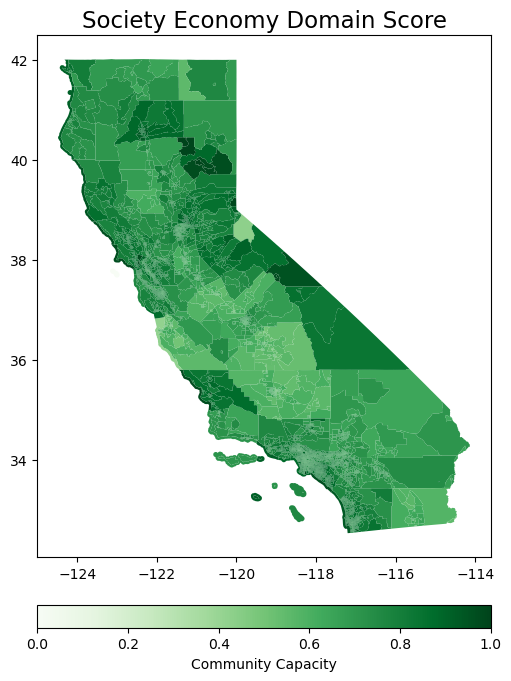

In [16]:
plot_domain_score(society_economy_domain_score, 
                  column_to_plot='society_economy_domain_score',
                  domain=domain_prefix)

### We can also visualize specific areas!
Here we'll use the specialized plotting function `plot_region_domain` function, which can handle county identifiers (their corresponding FIPS code) and pre-defined CA regions (listed below). For more information on the function, type `help(plot_region_domain)` to display additional context for all arguments. 

Pre-defined regions include: `bay_area`, `central_region`, `inland_deserts`, `north_central`, `northern`, `south_coast`, `slr_coast`. 

CA County FIPS Code Look-Up Table
|County: Code|County: Code|County: Code|County: Code|
|-----|----|-----|-----|
|Alameda: 001|Lassen: 035|San Benito: 069|Tehama: 103|
|Alpine: 003|Los Angeles: 037|San Bernardino: 071|Trinity: 105|
|Amador: 005|Madera: 039|San Diego: 073|Tulare: 107|
|Butte: 007|Marin: 041|San Francisco: 075|Tuolumne: 109|
|Calaveras: 009|Mariposa: 043|San Joaquin: 077|Ventura: 111|
|Colusa: 013|Mendocino: 045|San Luis Obispo: 079|Yolo: 113|
|Contra Costa: 015|Merced: 047|San Mateo: 081|Yuba: 115|
|Del Norte: 017|Modoc: 049| Santa Barbara: 083|
|El Dorado: 019|Mono: 051|Santa Clara: 085|
|Fresno: 019|Monterey: 053|Santa Cruz: 087|
|Glenn: 021|Napa: 055|Shasta: 089|
|Humboldt: 023|Nevada: 057|Sierra: 091|
|Imperial: 025|Orange: 059|Siskiyou: 095|
|Inyo: 027|Placer: 061|Solano: 095|
|Kern: 029|Plumas: 063|Sonoma: 097|
|Kings: 031|Riverside: 065|Stanislaus: 099|
|Lake: 033|Sacramento: 067|Sutter: 101|

You can plot a domains vulnerability index by region, specific county/counties, or the entirety of CA with labels. Below are a few example of each of these plotting scenarios. 

`help(plot_region_domain)`

Number of invalid geometries: 0


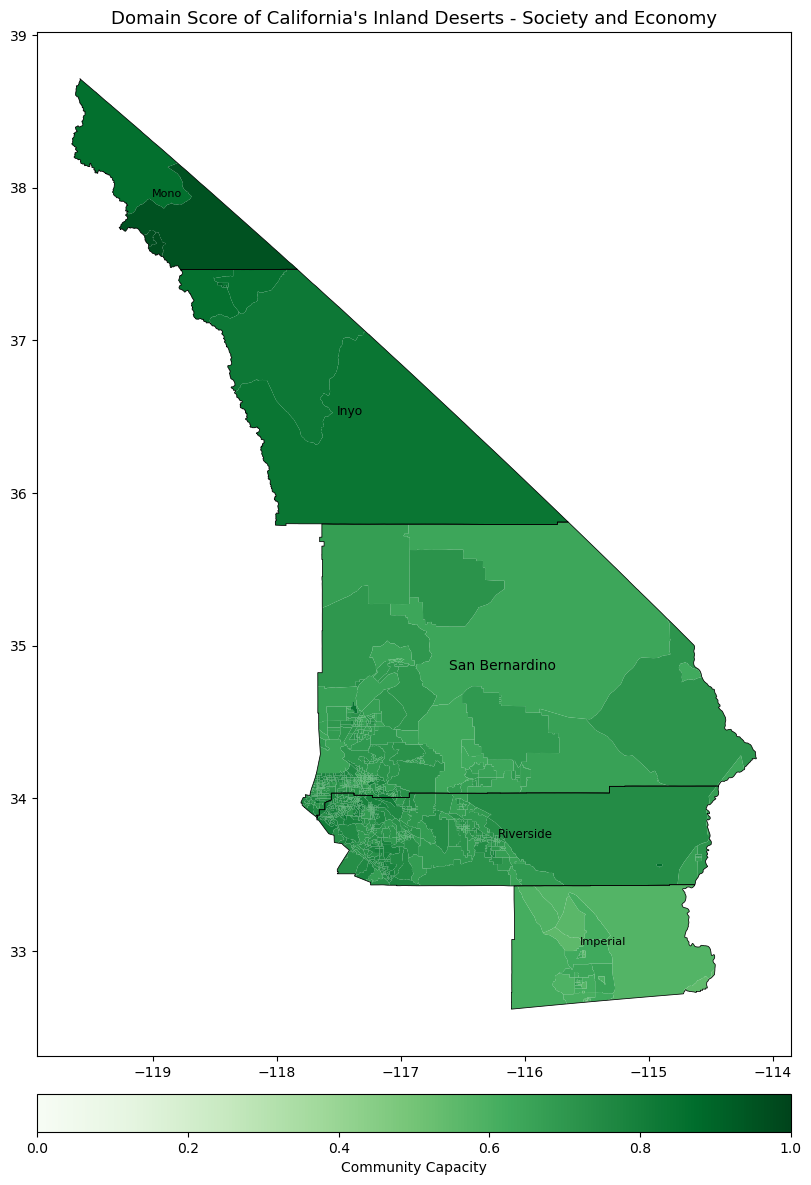

In [17]:
plot_region_domain(society_economy_domain_score,
                   column_to_plot='society_economy_domain_score',
                    domain=domain_prefix, 
                    domain_label_map={domain_prefix: 'Society and Economy'}, 
                    region='inland_deserts', 
                    savefig=False, 
                    font_color='black')

Number of invalid geometries: 0


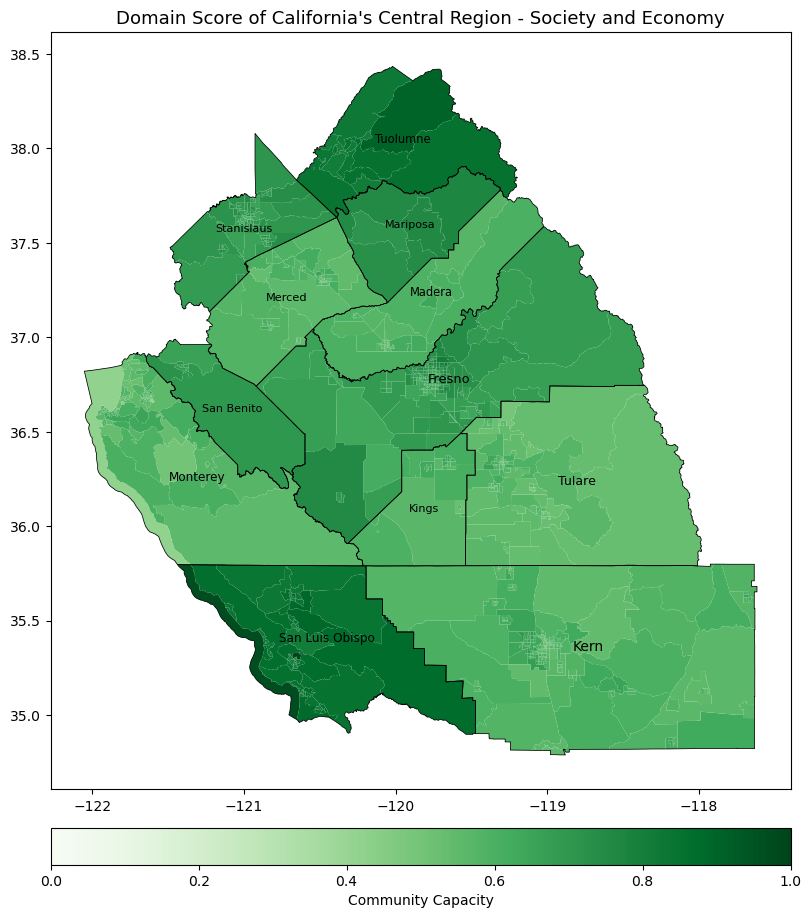

In [18]:
plot_region_domain(society_economy_domain_score,
                   column_to_plot='society_economy_domain_score',
                   domain=domain_prefix,
                   domain_label_map={domain_prefix: 'Society and Economy'},
                   region='central_region', 
                   savefig=False, 
                   font_color='black')

Number of invalid geometries: 0


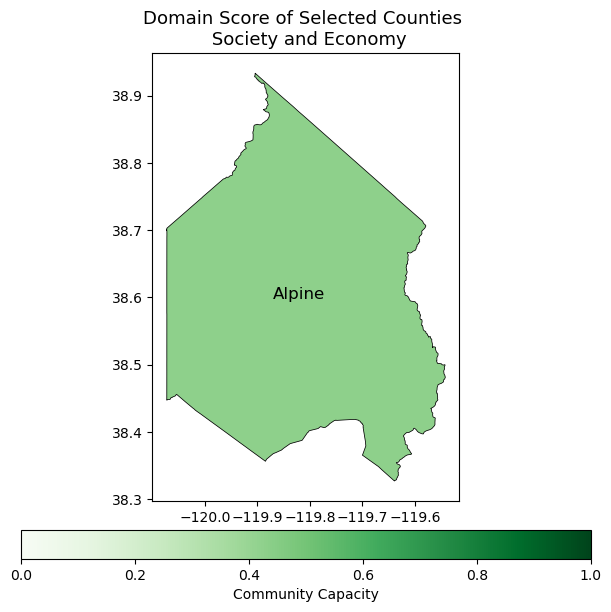

In [19]:
list_of_counties = ['003']
plot_region_domain(society_economy_domain_score,
                   column_to_plot='society_economy_domain_score',
                   counties_to_plot=list_of_counties, 
                   domain_label_map={domain_prefix: 'Society and Economy'},
                   savefig=False, 
                   font_color='black')

Number of invalid geometries: 0


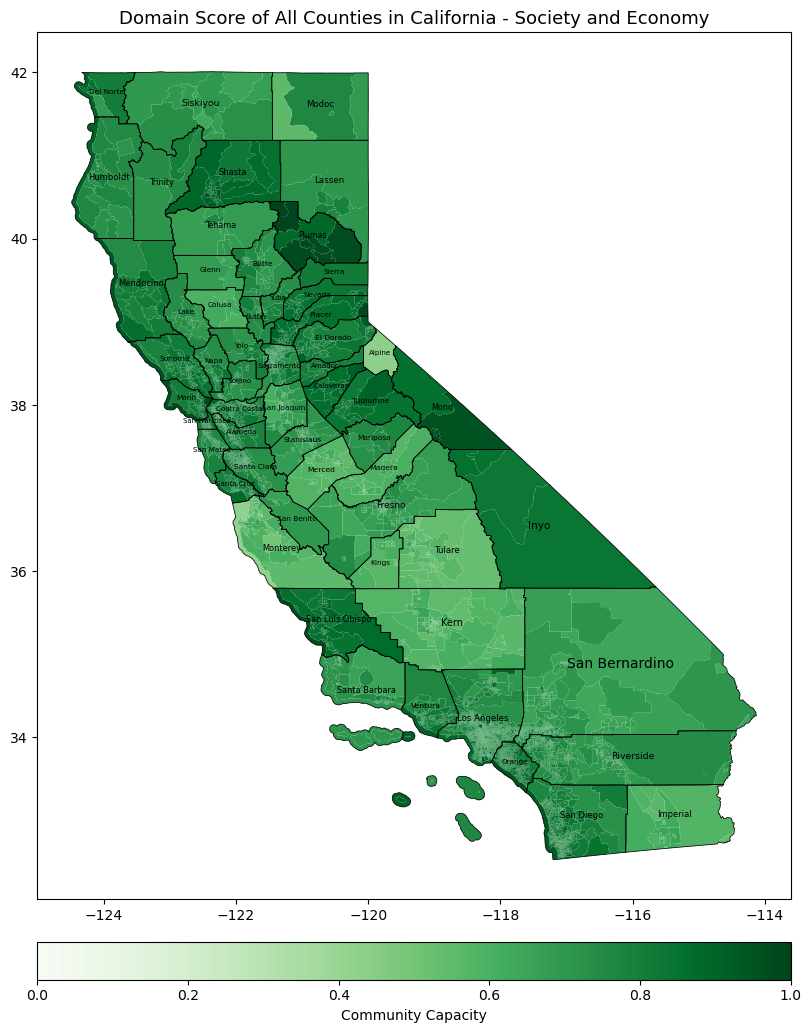

In [20]:
plot_region_domain(society_economy_domain_score,
                   column_to_plot='society_economy_domain_score',
                   domain_label_map={domain_prefix: 'Society and Economy'},
                   plot_all=True, 
                   savefig=False, 
                   font_color='black')

## Export the final domain csv file

In [21]:
# set-up file for export
domain_filename = '{}domain_score.csv'.format(domain_prefix)
society_economy_domain_score.to_csv(domain_filename, index=False)

## Upload the indicator and domain score csv files to AWS

In [22]:
# upload to aws bucket
bucket_name = 'ca-climate-index'
directory = '3_fair_data/index_data'

files_upload = indicator_filename, domain_filename

for file in files_upload:
    upload_csv_aws([file], bucket_name, directory)

society_economy_domain_averaged_indicators.csv uploaded to AWS
society_economy_domain_score.csv uploaded to AWS
